# Full implementation using the MNIST dataset.

In [1]:
%matplotlib inline

# Custom utility class
from utils import *

# pytorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

# Special package provided by pytorch
import torchvision
import torchvision.transforms as transforms

In [2]:
## Hyperparameters.

# If CUDA is enabled, use the GPU, otherwise use the CPU.
has_gpu = torch.cuda.is_available()

# image channel 3=RGB, 1=Grayscale
img_channels = 1

# Class labels.
classes = CLASS_LABELS['mnist']
num_classes = len(classes)

# Data directory.
data_dir = '../datasets/mnist'  # Dataset directory.
download = True                 # Download dataset iff not already downloaded.
normalize = 0.5                 # Normalize dataset.

# Training parameters
batch_size = 16  # Mini-batch size.
lr = 1e-2        # Optimizer's learning rate.
epochs = 5       # Number of full passes over entire dataset.

In [3]:
# Should normalize images or not.
# Normalization helps convergence.
if normalize:
    # Transform rule: Convert to Tensor, Normalize images in range -1 to 1.
    transform = transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize((0.5, 0.5, 0.5), 
                                                         (0.5, 0.5, 0.5))])
else:
    # Transform rule: Convert to Tensor without normalizing image
    transform = transforms.Compose([transforms.ToTensor()])

# Download the training set and apply the transform rule to each.
trainset = torchvision.datasets.MNIST(root=data_dir, train=True, download=download, transform=transform)
# Load the training set into mini-batches and shuffle them
trainset = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

# Download the testing set and apply the transform rule to each.
testset = torchvision.datasets.MNIST(root=data_dir, train=False, download=download, transform=transform)
# Load the testing set into mini-batches without shuffling.
testset = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Showing 16 images


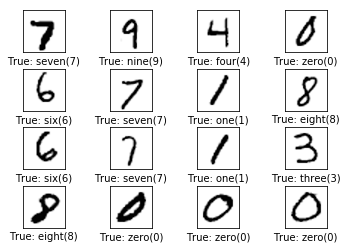

In [4]:
# Let's visualize some training set.
visualize(trainset, smooth=True, classes=classes)

In [5]:
class Network(nn.Module):
    
    def __init__(self, **kwargs):
        super(Network, self).__init__()
        
        # Hyper-parameters
        self._img_channels = kwargs.get('img_channels')
        self._num_classes = kwargs.get('num_classes')
        
        # 2 convolutional & 3 fully connected layers.
        self.conv1 = nn.Conv2d(self._img_channels, 16, 2)
        self.conv2 = nn.Conv2d(16, 32, 2)
        flatten_size = self.conv2.out_channels * 6 * 6
        self.fc1 = nn.Linear(flatten_size, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, self._num_classes)
    
    def forward(self, x):
        # Convolutional layers.
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        
        # Flatten layer.
        x = x.view(-1, self.__flatten(x))
        
        # Fully connected layers.
        x = F.relu(self.fc1(x))  # relu + linear
        x = F.dropout(x, p=0.2)  # 20% dropout
        x = F.relu(self.fc2(x))  # relu + linear
        
        # Output layer.
        x = self.fc3(x)  # linear
        
        return x
    
    def __flatten(self, x):
        size = x.size()[1:]  # Input shape excluding batch dim.
        return torch.Tensor(size).numel()

In [6]:
# Instantiate the network and pass in our parameters.
net = Network(img_channels=img_channels, num_classes=len(classes))

# Make use of GPU if it's available.
if has_gpu:
    net = net.cuda()

In [7]:
# Loss function criterion.
criterion = nn.CrossEntropyLoss()

# Adam optimizer.
optimizer = optim.Adam(net.parameters(), lr=lr)

In [8]:
# Loop over the data multiple times.
for epoch in range(epochs):

    # Loop through the training dataset (batch by batch).
    for i, data in enumerate(trainset):
        
        # Get the inputs and labels.
        inputs, labels = data
        
        # Wrap them in Variable (explained in section 2),
        # and optionaly do that on the GPU.
        if has_gpu:
            # Use GPU.
            inputs, labels = Variable(inputs.cuda()), Variable(inputs.cuda())
        else:
            # Use CPU.
            inputs, labels = Variable(inputs), Variable(labels)
        
        # Zero the optimizer gradient buffer to prevent gradient accumulation.
        optimizer.zero_grad()
        
        # Forward and backward propagation.
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        
        # Update learnable parameters w.r.t the loss.
        optimizer.step()
        
        # Print statistics.
        print(f'\rEpoch: {epoch+1:,}\t Batch: {i+1:,}\t Loss: {loss.data[0]:.4f}', end='')

    # Line break.
    print()


print('\nFinished training!')

Epoch: 1	 Batch: 3,750	 Loss: 0.0134
Epoch: 2	 Batch: 3,750	 Loss: 0.0976
Epoch: 3	 Batch: 3,750	 Loss: 0.1443
Epoch: 4	 Batch: 3,750	 Loss: 0.0001
Epoch: 5	 Batch: 3,750	 Loss: 0.0029

Finished training!


Showing 16 images


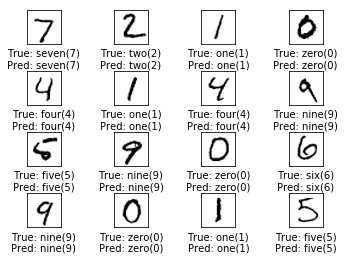

Accuracy of zero(0) 	 = 99.39%
Accuracy of one(1) 	 = 99.21%
Accuracy of two(2) 	 = 98.42%
Accuracy of three(3) 	 = 98.35%
Accuracy of four(4) 	 = 98.23%
Accuracy of five(5) 	 = 97.38%
Accuracy of six(6) 	 = 97.35%
Accuracy of seven(7) 	 = 97.33%
Accuracy of eight(8) 	 = 96.75%
Accuracy of nine(9) 	 = 95.44%
–––––––––––––––––––––––––––––––––––
Overall accuracy 	 = 97.78%
–––––––––––––––––––––––––––––––––––


In [10]:
# Visualize the testset, and it's prediction and,
# shows accuracy for each classes in the dataset.
accuracy(net=net, data=testset, classes=classes)